<a href="https://colab.research.google.com/github/DanielMerkdo/analitica_marketing/blob/main/preprocesamiento_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar entorno drive


In [197]:
# Montar drive y crear path para sys y para directorio de trabajo

from google.colab import drive
drive.mount('/content/drive')

import sys
import os

# Define el path al directorio de trabajo actual
path = "/content/drive/My Drive/cod/analitica_marketing"


sys.path.append(path) ### para importar archivo de funciones propias a través de import

os.chdir(path) ### para que por defecto suba y descargue archivos partiendo de esa ruta

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cargar las librerias


In [198]:
!pip install unidecode #(elimina caracteres especiales)

In [199]:
# Eliminar Warnings
#import warnings
#warnings.filterwarnings("ignore")
# Importar librerias
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install plotly
import plotly.express as px
!pip install mlxtend
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
import plotly.graph_objects as go
!pip install scikit-learn # install scikit-learn if you haven't already
##escalar fecha
from sklearn.preprocessing import MinMaxScaler # import MinMaxScaler

In [200]:
import a_funciones as funciones     # Importar las funciones
import importlib
importlib.reload(funciones)

<module 'a_funciones' from '/content/drive/MyDrive/cod/analitica_marketing/a_funciones.py'>

#Conectar Entorno SQL

In [201]:
#Conectar base de datos con el entorno sql
conex=sql.connect("data/db_movies") # conectarse a base de datos existentes


In [202]:
cur= conex.cursor() #para funciones que ejecutan sql en base de datos, otro tipo de conexión para ejecutar consultas en la bd sin traer ni llevar informacion

#Verificación BD y Lectura en Python


In [203]:
# consultar el nombre de las tablas en la base de datos
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('movies_final',),
 ('full_ratings',)]

In [ ]:
# Así se ven en sql toda la tabla movies
cur.execute("SELECT * FROM movies")
cur.fetchall()

In [ ]:
# Así se ven en sql toda la tabla ratings
cur.execute("SELECT * FROM ratings")
cur.fetchall()

In [206]:
# Leer la base de datos en el entorno de Python
df_movies= pd.read_sql("SELECT * FROM movies", conex)
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [207]:
df_movies.shape
print("La tabla movies tiene", df_movies.shape[0] ," filas y ",df_movies.shape[1] ,"columnas")

La tabla movies tiene 9742  filas y  3 columnas


In [208]:
df_movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [209]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [210]:
# Leer la base de datos en el entorno de Python
df_ratings= pd.read_sql("SELECT * FROM ratings", conex)
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [211]:
df_ratings.shape
print("La tabla ratings tiene", df_ratings.shape[0] ," filas y ",df_ratings.shape[1] ,"columnas")

La tabla ratings tiene 100836  filas y  4 columnas


In [212]:
df_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [213]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# EXPLORACIÓN CON SQL

In [214]:
### para verificar las tablas que hay disponibles
cur.execute("SELECT name FROM sqlite_master where type='table' ")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('movies_final',),
 ('full_ratings',)]

In [215]:
#Total de registros en la tabla ratings
pd.read_sql("select count(*) from ratings", conex)

,count(*)
0,100836


In [216]:
#Total de registros en la tabla movies
pd.read_sql("select count(*) from movies", conex)

,count(*)
0,9742


In [217]:
# Consultar el nombre de las columnas de la tabla "ratings"
column_names_query = "SELECT name FROM PRAGMA_TABLE_INFO('ratings')"
columns_ratings = pd.read_sql(column_names_query, conex)
columns_ratings

,name
0,userId
1,movieId
2,rating
3,timestamp


In [218]:
# Consultar el nombre de las columnas de la tabla "movies"
column_names_query = "SELECT name FROM PRAGMA_TABLE_INFO('movies')"
columns_movies = pd.read_sql(column_names_query, conex)
columns_movies

,name
0,movieId
1,title
2,genres


In [219]:
## Consultar los userld que han calificado peliculas en la plataforma
pd.read_sql("""select count(distinct userId) from ratings""", conex)


,count(distinct userId)
0,610


In [220]:
## Consultar los userld que aparecen más de una vez en la tabla ratings
query = """
SELECT
  userId,
  COUNT(*) AS cantidad
FROM ratings
GROUP BY userId
HAVING COUNT(*) > 1;
"""
df_user_counts = pd.read_sql(query, conex)
df_user_counts

,userId,cantidad
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44
...,...,...
605,606,1115
606,607,187
607,608,831
608,609,37


In [221]:
# Consultar los movieId que aparecen más de una vez en la tabla movies
query = """
SELECT
  movieId,
  COUNT(*) AS cantidad
FROM movies
GROUP BY movieId
HAVING COUNT(*) > 1;
"""
df_movie_counts = pd.read_sql(query, conex)
df_movie_counts

,movieId,cantidad


No se evidencian películas repetidas en la tabla movies

In [222]:
# Consultar registros duplicados en la tabla ratings
query = """
SELECT
    userId,
    movieId,
    rating,
    timestamp,
    COUNT(*) AS num_duplicates
FROM
    ratings
GROUP BY
    userId,
    movieId,
    rating,
    timestamp
HAVING
    COUNT(*) > 1;
"""
duplicate_records = pd.read_sql(query, conex)
duplicate_records

,userId,movieId,rating,timestamp,num_duplicates


No se evidencian registros duplicados en la tabla rating

In [223]:
# Consultar registros duplicados en la tabla movies
query = """
SELECT
    movieId,
    title,
    COUNT(*) AS num_duplicates
FROM
    movies
GROUP BY
    movieId,
    title
HAVING
    COUNT(*) > 1;
"""

duplicate_records = pd.read_sql(query, conex)
duplicate_records

,movieId,title,num_duplicates


No se evidencian registros duplicados en la tabla movies

In [224]:
# Consultar datos nulos en la tabla ratings
query = """
SELECT *
FROM ratings
WHERE userId IS NULL OR movieId IS NULL OR rating IS NULL OR timestamp IS NULL;
"""
null_records = pd.read_sql(query, conex)
null_records

,userId,movieId,rating,timestamp


No se evidencian datos nulos en la tabla ratings

In [225]:
# Consultar datos nulos en la tabla movies
query = """
SELECT *
FROM movies
WHERE title IS NULL OR genres IS NULL;
"""
null_records = pd.read_sql(query, conex)
null_records

,movieId,title,genres


No se evidencian datos nulos en la tabla movies

In [226]:
# Géneros en la tabla movies
genres_movies = pd.read_sql("SELECT DISTINCT genres FROM movies", conex)
print(genres_movies)

                                          genres
0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
..                                           ...
946            Adventure|Mystery|Sci-Fi|Thriller
947                   Action|Comedy|Crime|Horror
948             Action|Adventure|Children|Sci-Fi
949       Action|Adventure|Comedy|Fantasy|Sci-Fi
950              Action|Animation|Comedy|Fantasy

[951 rows x 1 columns]


In [228]:
# Distribución de la columna 'rating'
query_rating = """
SELECT
    rating,
    COUNT(*) AS frequency
FROM
    ratings
GROUP BY
    rating
ORDER BY
    rating;
"""
df_rating_dist = pd.read_sql_query(query_rating, conex)
print("Distribución de Rating:\n", df_rating_dist)
conex.close()

Distribución de Rating:
    rating  frequency
0     0.5       1370
1     1.0       2811
2     1.5       1791
3     2.0       7551
4     2.5       5550
5     3.0      20047
6     3.5      13136
7     4.0      26818
8     4.5       8551
9     5.0      13211


No se evidencian peliculas con calificación de 0 o no calificadas


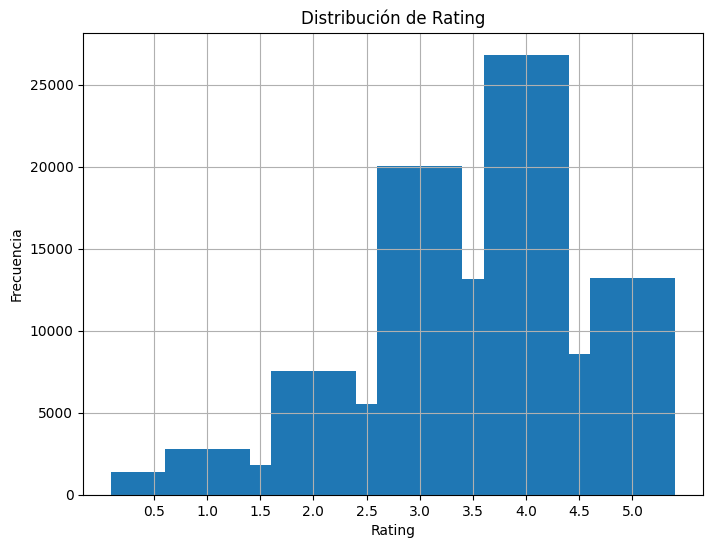

In [229]:
#Grafico de la distribucion del objeto Rating
plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura si es necesario
plt.bar(df_rating_dist['rating'], df_rating_dist['frequency'])
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Rating')
plt.xticks(df_rating_dist['rating'])  # Mostrar todos los valores de rating en el eje x
plt.grid(True)
plt.show()

In [230]:
conex = sql.connect("data/db_movies")

In [231]:
### calcular cada usuario cuantas peliculas califico
ratings_usersconteo= pd.read_sql("""select "userId" as user_id,
                                count(*)as calificaciones
                                from ratings
                                group by "userId"
                                order by calificaciones asc
                                """, conex)
fig = px.histogram(
    ratings_usersconteo,
    x="calificaciones",
    title="Número de calificaciones",
    nbins=10,
    labels={"calificaciones": "Número de calificaciones", "count": "Cantidad de usuarios"}
)
fig.show()

La gran mayoria de usuarios, aprox 566, han calificado entre 0 y 500 peliculas

In [92]:
ratings_usersconteo.describe()

,user_id,calificaciones
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


In [93]:
###Tabla de usuarios que calificaron mas de 20 películas y menos de 400
ratings_users2= pd.read_sql("""select "userId" as user_id,
                                count(*)as calification
                                from ratings
                                group by "userId"
                                having calification between 20 and 400
                                order by calification asc
                                """, conex)
ratings_users2

,user_id,calification
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
...,...,...
544,391,386
545,514,397
546,156,398
547,45,399


In [232]:
### Histograma de usuarios que calificaron mas de 20 películas y menos de 400
fig= px.histogram(ratings_users2, x="calification", title= "Numero de calificaciones", nbins=10,
    labels={"calification": "Número de calificaciones", "count": "Cantidad de usuarios"})
fig.show()


In [233]:
ratings_users2.describe()

,user_id,calification
count,549.000000,549.000000
mean,301.646630,96.027322
std,173.896885,86.378671
min,1.000000,20.000000
25%,151.000000,34.000000
50%,303.000000,60.000000
75%,450.000000,129.000000
max,609.000000,400.000000


In [234]:
#### verificar cuantas calificaciones tiene cada pelicula
rating_movies=pd.read_sql(''' select movieId ,
                         count(*) as numero_calificaciones
                         from ratings
                         group by movieId
                         order by numero_calificaciones desc
                         ''',conex )


fig = px.histogram(
    rating_movies,
    x="numero_calificaciones",
    nbins=30,  # puedes ajustar este número según la dispersión de tus datos
    labels={
        "numero_calificaciones": "Número de calificaciones por película",
        "count": "Cantidad de películas"
    },
    title="Distribución de calificaciones por película"
)

fig.show()

La gran mayoria de peliculas, aproximadamente 8400, tienen entre 0 y 20 calificaciones

In [235]:
### analizar distribucion de calificaciones por pelicula
rating_movies.describe()

,movieId,numero_calificaciones
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


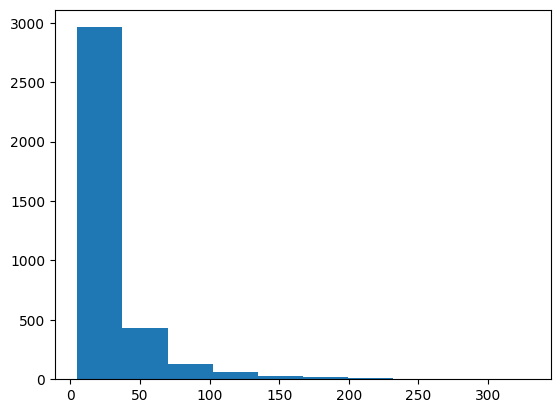

In [236]:
####Solo incluir peliculas que tengan 5 o mas calificaciones
rating_movies2=pd.read_sql(''' select movieId ,
                         count(*) as numero_calificaciones
                         from ratings
                         group by movieId
                         having numero_calificaciones>=5
                         order by numero_calificaciones desc
                         ''',conex)


fig  = plt.hist(rating_movies2['numero_calificaciones'])

In [237]:
rating_movies2.describe()

,movieId,numero_calificaciones
count,3650.000000,3650.000000
mean,23839.433151,24.732603
std,38394.748531,31.703576
min,1.000000,5.000000
25%,1784.250000,7.000000
50%,3866.000000,13.000000
75%,36664.750000,28.000000
max,187595.000000,329.000000


# ANALISIS PREPROCESAMIENTO JAVI

In [238]:
#Conectar base de datos con el entorno sql
conex=sql.connect("data/db_movies") # conectarse a base de datos existentes
cur= conex.cursor() #para funciones que ejecutan sql en base de datos, otro tipo de conexión para ejecutar consultas en la bd sin traer ni llevar informacion

In [240]:
funciones.ejecutar_sql('preprocesamiento.sql', cur)

In [241]:
cur.execute("select name from sqlite_master where type='table' ")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('movies_final',),
 ('full_ratings',)]

In [242]:
####movies - registros tabla inicial

pd.read_sql('select count(*) from movies', conex)


,count(*)
0,9742


In [243]:
pd.read_sql('select count(*) from movies_final', conex)
# registros tabla filtrada

,count(*)
0,3268


In [244]:
##ratings - registro tabla inicial
pd.read_sql('select count(*) from ratings', conex)


,count(*)
0,100836


In [245]:
pd.read_sql('select count(*) from ratings_final', conex)
#registros tabla filtrada

,count(*)
0,48767


In [246]:
## verificacion tabla final ###
pd.read_sql('select count(*) from full_ratings', conex)

ratings=pd.read_sql('select * from full_ratings',conex)
ratings.duplicated().sum() ## al cruzar tablas a veces se duplican registros
ratings.info()
ratings.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48767 entries, 0 to 48766
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       48767 non-null  int64  
 1   movie_Id      48767 non-null  int64  
 2   movie_rating  48767 non-null  float64
 3   rating_time   48767 non-null  int64  
 4   movie_title   48767 non-null  object 
 5   movie_genre   48767 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.2+ MB


,user_id,movie_Id,movie_rating,rating_time,movie_title,movie_genre
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


In [256]:
df_ratings = pd.read_sql('SELECT * FROM full_ratings', conex)

In [257]:
# Separar por paréntesis
sep = df_ratings['movie_title'].str.split('(', n=1)

# Extraer el año y limpiarlo
df_ratings['movie_year'] = sep.str[1].str.replace(')', '', regex=False)

# Extraer el título limpio (sin el año)
df_ratings['movie_title'] = sep.str[0].str.strip()

#Orden de las columnas
df_ratings = df_ratings[['user_id', 'movie_Id', 'movie_rating', 'rating_time', 'movie_title', 'movie_year', 'movie_genre']]

In [258]:
df_ratings

,user_id,movie_Id,movie_rating,rating_time,movie_title,movie_year,movie_genre
0,1,1,4.0,964982703,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men,1995,Comedy|Romance
2,1,6,4.0,964982224,Heat,1995,Action|Crime|Thriller
3,1,47,5.0,964983815,Seven,a.k.a. Se7en (1995,Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The",1995,Crime|Mystery|Thriller
...,...,...,...,...,...,...,...
48762,609,828,3.0,847221054,"Adventures of Pinocchio, The",1996,Adventure|Children
48763,609,833,3.0,847221080,High School High,1996,Comedy
48764,609,892,3.0,847221080,Twelfth Night,1996,Comedy|Drama|Romance
48765,609,1056,3.0,847221080,Jude,1996,Drama


In [259]:
from mlxtend.preprocessing import TransactionEncoder

# Separar los géneros en la columna 'movie_genre' por el delimitador '|'
genres = df_ratings['movie_genre'].str.split('|')

# Aplicar el TransactionEncoder para transformar los géneros
te = TransactionEncoder()
genres_encoded = te.fit_transform(genres)

# Crear un DataFrame con los géneros transformados
genres_df = pd.DataFrame(genres_encoded, columns=te.columns_)

# Concatenar los géneros transformados con el DataFrame original (sin sobrescribir los géneros originales)
df_ratings = pd.concat([df_ratings, genres_df], axis=1)

# Ver el resultado
df_ratings.head()

,user_id,movie_Id,movie_rating,rating_time,movie_title,movie_year,movie_genre,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1,3,4.0,964981247,Grumpier Old Men,1995,Comedy|Romance,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,1,6,4.0,964982224,Heat,1995,Action|Crime|Thriller,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,1,47,5.0,964983815,Seven,a.k.a. Se7en (1995,Mystery|Thriller,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4,1,50,5.0,964982931,"Usual Suspects, The",1995,Crime|Mystery|Thriller,False,False,False,...,False,False,False,False,True,False,False,True,False,False


In [260]:
print(df_ratings.columns)

Index(['user_id', 'movie_Id', 'movie_rating', 'rating_time', 'movie_title',
       'movie_year', 'movie_genre', '(no genres listed)', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [261]:
# Eliminar la columna 'movie_genre'
df_ratings = df_ratings.drop(columns=['movie_genre'])

# Verifica los primeros registros para comprobar el cambio
df_ratings.head()

,user_id,movie_Id,movie_rating,rating_time,movie_title,movie_year,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story,1995,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,3,4.0,964981247,Grumpier Old Men,1995,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,1,6,4.0,964982224,Heat,1995,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1,47,5.0,964983815,Seven,a.k.a. Se7en (1995,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4,1,50,5.0,964982931,"Usual Suspects, The",1995,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


In [262]:
unique_years = df_ratings['movie_year'].unique()

# Mostrar los valores únicos
print(unique_years)

['1995' 'a.k.a. Se7en (1995' '1996' '1994' 'Dumb and Dumber (1994' '1977'
 '1993' '1990' '1989' '1991' '1940' 'a.k.a. ID4 (1996' '1939' '1941'
 '1938' '1947' '1975' '1968' '1945' '1963' '1971' '1951' '1979' '1992'
 '1986' '1982' '1980' '1987'
 'Indiana Jones and the Raiders of the Lost Ark (1981' '1983' '1960'
 '1952' '1984' '1933' '1985' '1974'
 'Nosferatu, eine Symphonie des Grauens (1922' '1997' 'a.k.a. MIB (1997'
 '1998' '1930' '1976' '1942' '1967' '1959' '1946' '1978' '1973' '1988'
 '1999' '1931' 'Lola rennt (1998' 'a.k.a. Ghost Busters (1984' '1981'
 '1964' '1962' '1965' '1969' '2000' 'Mad Max 2 (1981' 'a.k.a. MASH (1970'
 '2003' '2004' '2006' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '1970' '1955' '2002' 'a.k.a. 12 Monkeys (1995' 'Postino, Il (1994'
 'Yin shi nan nu (1994' 'Como agua para chocolate (1992' '1961' '1954'
 '1957' 'Himmel über Berlin, Der (1987' 'Ma vie en rose (1997'
 'a.k.a. Buffalo 66 (1998' 'Shichinin no samurai (1954' '1943'
 'La Vita è bella (19

#ANALISIS PREPROCESAMIENTO DANIEL

In [ ]:
### Tabla de acuerdo a la calificacion de cada pelicula, top 10 de las mas calificadas
ratings_movies= pd.read_sql("""select "movieId" as movie_id,
                                count(*)as calification
                                from ratings
                                group by "movieId"
                                order by calification desc
                                limit 10
                                """, conex)
ratings_movies

,movie_id,calification
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
5,260,251
6,480,238
7,110,237
8,589,224
9,527,220


In [ ]:
### Convertirlas a tipo string
ratings_movies= ratings_movies.astype({'movie_id': 'str'})
ratings_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_id      10 non-null     object
 1   calification  10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes


In [ ]:
### Grafico top 10 más calificadas
data= go.Bar(x= ratings_movies.movie_id, y= ratings_movies.calification, text=ratings_movies.calification)
Layout= go.Layout(title="Total de calificaciones por pelicula", xaxis=dict(title="movieId"))
fig= go.Figure(data, Layout)
fig.show()

In [ ]:
#func.ejecutar_sql(analitica_marketing, cur)
#cur.execute("select name from sqlite master where type= table' ")
#cur.fetchall()

In [ ]:
### Obtener generos y convertirlos a boleanos
movies= pd.read_sql("select * from movies", conex)
genres = genres_movies["genres"].str.split("|").tolist() # Get genres and convert to list of lists
te = TransactionEncoder()
genres_encoded = te.fit_transform(genres)
genres = pd.DataFrame(genres_encoded, columns=te.columns_)
genres = genres.drop(["(no genres listed)"], axis=1) # Assuming you want to drop this column
genres2 = genres.copy()
genres2.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
genres2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951 entries, 0 to 950
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Action       951 non-null    bool 
 1   Adventure    951 non-null    bool 
 2   Animation    951 non-null    bool 
 3   Children     951 non-null    bool 
 4   Comedy       951 non-null    bool 
 5   Crime        951 non-null    bool 
 6   Documentary  951 non-null    bool 
 7   Drama        951 non-null    bool 
 8   Fantasy      951 non-null    bool 
 9   Film-Noir    951 non-null    bool 
 10  Horror       951 non-null    bool 
 11  IMAX         951 non-null    bool 
 12  Musical      951 non-null    bool 
 13  Mystery      951 non-null    bool 
 14  Romance      951 non-null    bool 
 15  Sci-Fi       951 non-null    bool 
 16  Thriller     951 non-null    bool 
 17  War          951 non-null    bool 
 18  Western      951 non-null    bool 
dtypes: bool(19)
memory usage: 17.8 KB


In [ ]:
conex = sql.connect("data/db_movies")
cur = conex.cursor()

In [ ]:
##Insertar la columna de movield y el title
if "movieId" not in genres2.columns:
    genres2.insert(0, "movieId", movies["movieId"])
if "title" not in genres2.columns:
    genres2.insert(1, "title", movies["title"])
genres2.to_sql("genres2", conex, if_exists="replace")
cur.execute("ALTER TABLE genres2 ADD COLUMN fecha INTEGER")

In [ ]:
### Extraer año del título estreno de la película
cur.execute("""
    UPDATE genres2
    SET fecha = CAST(SUBSTR(title, -5, 4) AS INTEGER)
""")

movies2 = pd.read_sql("SELECT * FROM genres2", conex)
movies2.head()

,index,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,fecha
0,0,1,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,1,2,Jumanji (1995),0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
4,4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [ ]:
## Escalar fecha
sc= MinMaxScaler()
movies2["fecha"]= sc.fit_transform(movies2[["fecha"]])
movies2.to_sql("movies2", conex, if_exists="replace")

movies3= movies2.drop(columns=[ "title", "index", "fecha", "movieId"])
movies3.to_sql("movies3", conex, if_exists="replace")

951

In [ ]:
### Utilizar tabla de rating final para los modelos
rating_final= pd.read_sql("select * from ratings", conex)

rating_final["fecha"]= pd.read_sql("select fecha from movies2", conex)

ratings1= rating_final.copy()
ratings1.head()

,userId,movieId,rating,timestamp,fecha
0,1,1,4.0,964982703,0.969231
1,1,3,4.0,964981247,0.969231
2,1,6,4.0,964982224,0.969231
3,1,47,5.0,964983815,0.969231
4,1,50,5.0,964982931,0.969231


In [ ]:
### Se elimina el timestamp de la tabla de ratings, para no afectar los sistemas de recomendacion
ratings1= ratings1.drop(columns=["timestamp"])

ratings1.to_sql("ratings1", conex, if_exists="replace")


100836

In [ ]:
### Crear una tabla para los modeleos finales
ratingtittle= pd.read_sql("""select b.*,a.title
                            from ratings1 b left join movies a on b.movieId=a.movieId
                            """, conex)
ratingtittle.head()

,index,userId,movieId,rating,fecha,title
0,0,1,1,4.0,0.969231,Toy Story (1995)
1,1,1,3,4.0,0.969231,Grumpier Old Men (1995)
2,2,1,6,4.0,0.969231,Heat (1995)
3,3,1,47,5.0,0.969231,Seven (a.k.a. Se7en) (1995)
4,4,1,50,5.0,0.969231,"Usual Suspects, The (1995)"
